# HRTEM Introduction

This notebook demonstrates the basic functionality of PyQSTEM with ASE.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from ase.build import mx2
from pyqstem import PyQSTEM
from pyqstem.imaging import CTF
from pyqstem.util import atoms_plot
mpl.rc('font',**{'size' : 13})

We start by creating a model of MoS2 using the mx2 function from ASE. This function returns a hexagonal unit cell, while QSTEM requires an orthorhombic cell, hence a few addtional lines of code is necessary to transform the cell.

In [2]:
atoms=mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(2, 2, 1), vacuum=3)

cell=atoms.get_cell()
cell[1,0]=0
atoms.set_cell(cell)

atoms.wrap() # wrap atoms outside the unit cell 
atoms.center() # center the atoms in the unit cell

We can view the resulting structure using the atoms_plot() function, below we also use matplotlibs subplots to create two plots side-by-side. Alternatively we could use ASE's view function to see the structure in 3d. When running QSTEM the wavefunction is propagated from $z=0$ to the bottom of the unit cell.

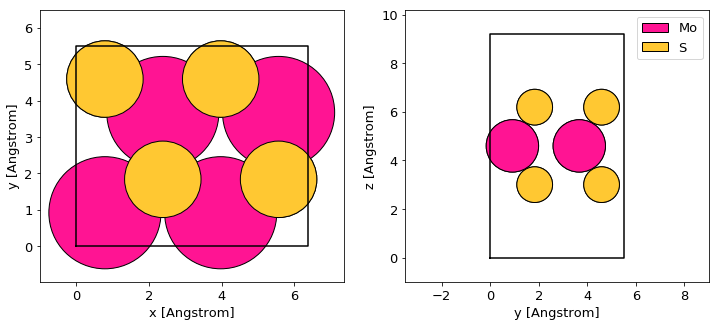

In [3]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
atoms_plot(atoms,ax=ax1)
atoms_plot(atoms,ax=ax2,scale_atoms=.7,direction=0,legend=True)

We create the PyQSTEM object in TEM mode and build a simple plane wave with an accelerating voltage $v_0 = 300 \ \mathrm{keV}$ and a sampling of 300x300 pixels. This also the number of samples used for the potential.

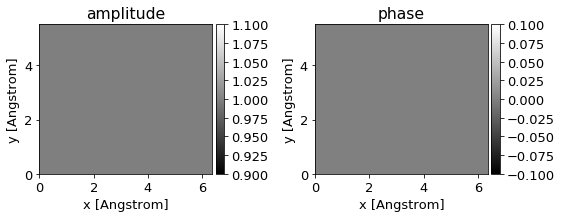

In [4]:
qstem = PyQSTEM('TEM')

qstem.set_atoms(atoms)

v0=300
qstem.build_wave('plane',v0,(300,300))

wave=qstem.get_wave()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
wave.view(method='amplitude',ax=ax1)
wave.view(method='phase',ax=ax2)
plt.tight_layout()

The .build_potential() method is then used to build the electrostatic potential using the parameterization of the electron scattering factors by Rez et al..

In [5]:
num_slices=10
qstem.build_potential(num_slices)

When the potential is build it exists only internally in QSTEM. To retrieve the potential to Python use .get_potential_or_transfunc(), this returns either the potential or the transmission function depending on whether the .run() method have been called. The reason for this is that the internal potential array gets overwritten during a calculation in order to conserve memory.

In [6]:
potential=qstem.get_potential_or_transfunc()

A projection of the potential can be viewed using the .view() method.

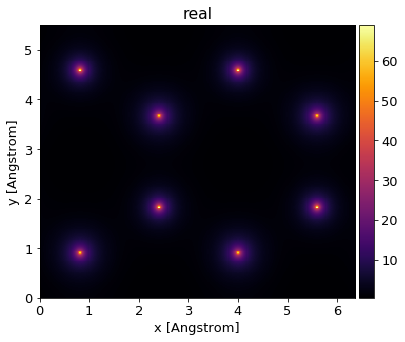

In [7]:
potential.view(method='real',cmap='inferno')

To propagate the wave function use the .run() method.

In [8]:
qstem.run()

The wave have now been propagated through the potential. Below we retrieve it from QSTEM, creating a wave object in Python. This object holds the complex array as well as the energy and sampling. 

Energy (in keV): 300.0
Sampling (in Angstrom): (0.02120000123977661, 0.01835973933339119)
Lateral extent (in Angstrom): [0, 6.360000371932983, 0, 5.507921800017357]


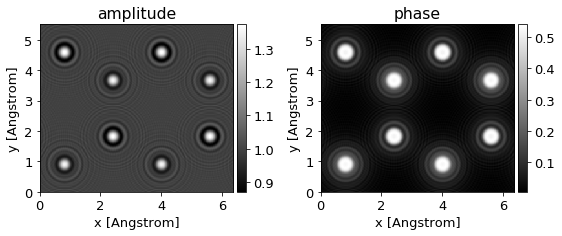

In [9]:
wave=qstem.get_wave()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
wave.view(method='amplitude',ax=ax1)
wave.view(method='phase',ax=ax2)
plt.tight_layout()

print('Energy (in keV):',wave.energy)
print('Sampling (in Angstrom):',wave.sampling)
print('Lateral extent (in Angstrom):',wave.get_extent())

We have created the exit wave, which now have to be passed through the objective lens. To simulate this using Fourier space multiplication with the contrast transfer function (CTF), we use the CTF object.

Partial temporal coherence is included by applying an envelope to the wavefunction (quasi-coherent approximation). The envelope is controlled by the focal spread, $\Delta$, which is related to energy spread and lens instability as
$$\Delta =  C_c \sqrt{\left(\frac{\Delta E}{E}\right)^2+2\left(\frac{\Delta I}{I}\right)^2}$$
where $C_c$ is the chromatic aberration, $E$ is the beam energy, $\Delta E$ is the standard deviation of the energy spread, $I$ is the lens current and $\Delta I$ is the standard deviation of the lens current instability.

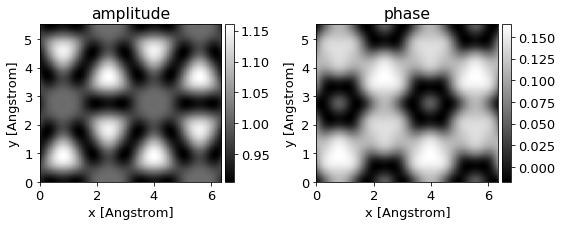

In [10]:
ctf = CTF(defocus=50,Cs=5*10**4,focal_spread=30)
img_wave=wave.apply_ctf(ctf)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
img_wave.view(method='amplitude',ax=ax1)
img_wave.view(method='phase',ax=ax2)
plt.tight_layout()

To see a radial plot of the CTF use the .radial_plot() method.

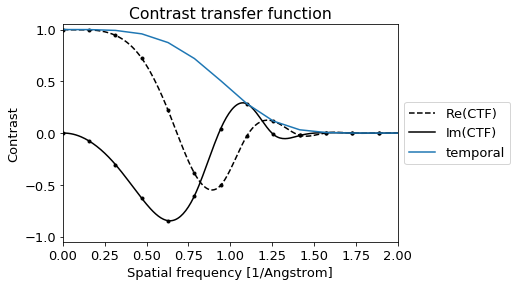

In [11]:
ctf.radial_plot(interpolate=True)

The detected image is simply the absolute square of the wavefunction at the image plane, however we may want to do some addtional processing:

Detector resolutions are typically worse than what is required by the multislice algorithm, hence the image needs to be downsampled to the correct resolution. 

Optionally, shot noise can be is simulated by specifying a finite electron dose. The mean of the Poisson distribution is given by

$$ \bar{N} = D\delta^2 I $$

where $D$ is the dose in electrons per Angstrom, $\delta^2$ is the pixel area and $I$ is absolute square of the wavefunction. The simulation does not include other sources of noise e.g. thermal noise.

Lastly, the Modulation Transfer Function (MTF) of the detector and additional imagespread due to thermal magnetic noise is important for experimental agreement at an absolute contrast scale.

All of this can be included using the .detect() method.

In [17]:
resample=.18 # Angstrom/pixel
dose=1*10**4 #electrons/Angstrom squared
img=img_wave.detect(dose=dose,resample=resample) # returns a numpy array

C:\Users\jacob\Anaconda3\envs\qstem\lib\json\encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-18 10:02:39.469897. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


We can use matplotlib to show the resulting numpy array. Note that the image is transposed since the convention used by PyQSTEM is to take the zero'th array dimension as the x-axis.

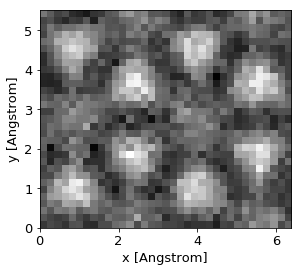

C:\Users\jacob\Anaconda3\envs\qstem\lib\json\encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-03-18 10:01:27.474673. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [13]:
plt.imshow(img.T,extent=img_wave.get_extent(),cmap='gray',interpolation='nearest')
plt.xlabel('x [Angstrom]')
plt.ylabel('y [Angstrom]')
plt.show()